In [5]:
import os
import sys
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import openpolicedata as opd

In [6]:
# To access the data, create a source using a Source Name (usually a police department name). There is an optional state input to clarify ambiguities.
# Create data source for Denver''s police department
agency="Denver"
src = opd.Source(source_name=agency, state="Colorado")
src.datasets.head()

,State,SourceName,Agency,TableType,Year,Description,DataType,URL,date_field,dataset_id,agency_field,min_version,readme
7,Colorado,Denver,Denver,STOPS,MULTI,Police Pedestrian Stops and Vehicle Stops,ArcGIS,https://services1.arcgis.com/zdB7qR0BtYrg0Xpl/...,TIME_PHONEPICKUP,<NA>,<NA>,<NA>,<NA>
8,Colorado,Denver,Denver,OFFICER-INVOLVED SHOOTINGS,MULTI,This dataset includes incidents in which one o...,CSV,https://www.denvergov.org/media/gis/DataCatalo...,INCIDENT_DATE,<NA>,<NA>,<NA>,https://view.officeapps.live.com/op/view.aspx?...


In [7]:
# Find out what types of data are available from this source

types = src.get_tables_types()

print(types)

['STOPS', 'OFFICER-INVOLVED SHOOTINGS']


In [8]:
# Find out what years are available from the stops table
active_data_type = types[0]
years = src.get_years(table_type=active_data_type)
print(years)

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [9]:
# Load data from the source for the Denver County Police Department in 2021
active_year = 2011
t = src.load_from_url(year=active_year, table_type=active_data_type)

In [10]:
# Show the columns
t.table.head(1)

,OBJECTID,MASTER_INCIDENT_NUMBER,PRIORITY_DESCRIPTION,PROBLEM,ADDRESS,CALL_CLASS,TIME_PHONEPICKUP,CALL_DISPOSITION,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_NAME,GLOBALID,geometry
0,3077585,DPD-11-0437880,P3 Public Need,Vehicle Stop,S Monaco Cir / S Monaco St,2,2011-10-01 01:23:03,In Service,3165235.33,1635925.11,-104.913789,39.577936,None,None,None,2d67b983-1afc-4c12-a62e-c792999586c4,POINT (3165235.332 1635925.108)


In [11]:
# Convert geometry to lat long
t.table['geometry']=t.table['geometry'].to_crs(crs='EPSG:4326')
t.table.head(3)

,OBJECTID,MASTER_INCIDENT_NUMBER,PRIORITY_DESCRIPTION,PROBLEM,ADDRESS,CALL_CLASS,TIME_PHONEPICKUP,CALL_DISPOSITION,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_NAME,GLOBALID,geometry
0,3077585,DPD-11-0437880,P3 Public Need,Vehicle Stop,S Monaco Cir / S Monaco St,2,2011-10-01 01:23:03,In Service,3165235.33,1635925.11,-104.913789,39.577936,None,None,None,2d67b983-1afc-4c12-a62e-c792999586c4,POINT (-104.91380 39.57794)
1,3077586,DPD-11-0073081,P3 Public Need,Subject Stop,7621 S Broadway,2,2011-02-14 10:27:53,Quit,3144191.88,1635926.13,-104.988444,39.578288,None,None,None,472f2c6e-8bdc-43bb-ad31-bef85969360e,POINT (-104.98845 39.57830)
2,3077599,DPD-11-0038516,P3 Public Need,Subject Stop,7070 S Sheridan Blvd,2,2011-01-24 16:25:26,Arrest Made,3125738.11,1639893.56,-105.053843,39.589447,None,None,None,00510d40-507b-4a00-94d8-727336ff51b5,POINT (-105.05385 39.58945)


In [12]:
# Download and load the police districts shape file
import requests
import zipfile

shape_file_url = r'https://www.denvergov.org/media/gis/DataCatalog/police_districts/shape/'

home_folder = Path('..')

police_districts_base_filename = 'police_districts'
police_districts_zip_filename = police_districts_base_filename + ".zip"
police_districts_dir = home_folder / 'data' / police_districts_base_filename
police_districts_zip_full_filename =  police_districts_dir / police_districts_zip_filename

if not police_districts_dir.is_dir():
    os.makedirs(police_districts_dir)

res = requests.get( shape_file_url + police_districts_zip_filename )
res.raise_for_status()

print(f"Downloading {police_districts_zip_filename} from {shape_file_url}."  )
with open(police_districts_zip_full_filename, 'wb') as f:
    print(".",end='',flush=True)
    f.write(res.content)

#Extract the data from the file
police_districts_zip = zipfile.ZipFile(police_districts_zip_full_filename)

print(f"Unzipping {police_districts_zip_full_filename}. The files are: "  )
print(police_districts_zip.namelist())

police_districts_zip.extractall(police_districts_dir)
police_districts_zip.close()


.Unzipping ../data/police_districts/police_districts.zip. The files are: 
['police_districts.dbf', 'police_districts.prj', 'police_districts.sbn', 'police_districts.sbx', 'police_districts.shp', 'police_districts.shp.xml', 'police_districts.shx']


NameError: name 'jurisdiction' is not defined

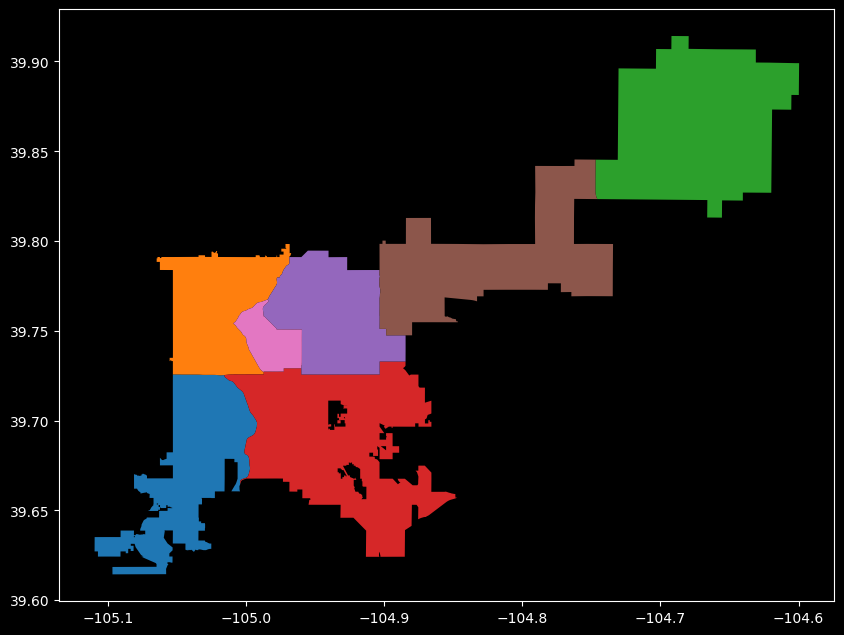

In [13]:
# Load the shape file and plot it 
# On Windows, if there is an error when the shape file is read in below, fiona may not be installed properly. 
# See here: https://fiona.readthedocs.io/en/latest/README.html#installation
import matplotlib.colors as mcolors

# Load the shape file and plot it 
police_districts_shp_filename = police_districts_base_filename + ".shp"
police_districts_shp_full_filename =  police_districts_dir / police_districts_shp_filename
map_df = gpd.read_file(police_districts_shp_full_filename)
total_districts = set(map_df["DIST_NUM"])

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,10))

for (color_name, color_value), current_district in zip(mcolors.TABLEAU_COLORS.items(), total_districts):
    district_map = map_df[current_district==map_df["DIST_NUM"]]
    district_map.plot(ax=ax, facecolor=color_name)

# Add title
plt.title(f" {jurisdiction} Police District Locations")

# Remove empty white space around the plot
plt.tight_layout()


In [ ]:
# Now associate the number of stops with a district
# This takes a while to run

INVALID_REGION_IDX = -1
def find_region(event_loc, district_map):
    active_region_idx=[ idx  for idx in range(len(district_map)) if district_map[idx].contains(event_loc).bool()]
    if len(active_region_idx) == 0:
        return INVALID_REGION_IDX
    elif len(active_region_idx) == 1:
        return active_region_idx[0]
    else:
        raise ValueError("Expected none or one region")



# Link a district with a stop
district_map = [map_df[current_district==map_df["DIST_NUM"]] for current_district in total_districts]
t.table['REGION_IDX'] = t.table['geometry'].apply(lambda x: find_region(x,district_map) )

# Show the column has been added
district_region_totals=t.table.groupby(['REGION_IDX']).size()

district_region_totals_list = [x for x in district_region_totals]

# Skip the invalid index
map_df['Count']=district_region_totals_list[1:]
map_df.head(2)

,DIST_NUM,SHAPE_Leng,SHAPE_Area,geometry,Count
0,6,0.159844,0.001126,"POLYGON ((-104.97812 39.75116, -104.97812 39.7...",10382
1,1,0.379425,0.004253,"POLYGON ((-104.97165 39.79832, -104.96874 39.7...",11029


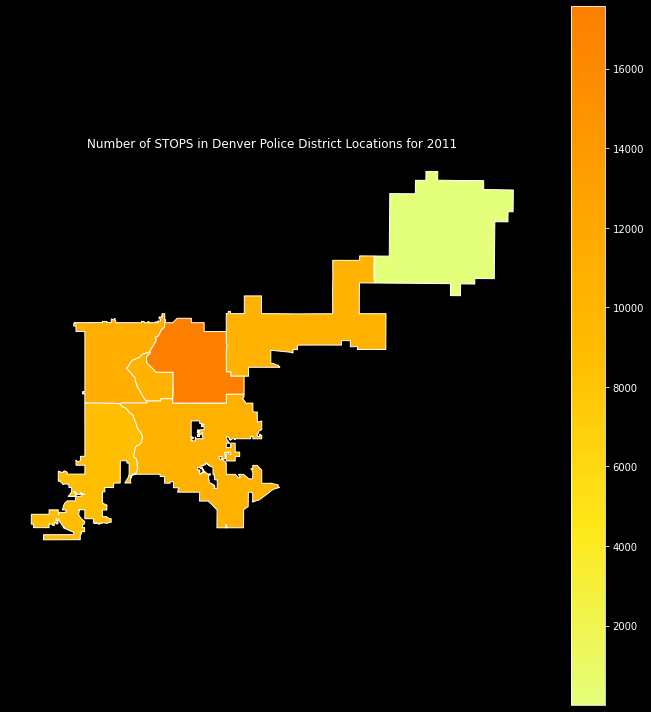

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10,10))

# Other cmap choices include: Wistia, magma_r, YlGn
map_df.plot(ax=ax, column='Count', edgecolor='w', cmap='Wistia',alpha=1, linewidth=1, legend=True)

plt.title(f"Number of {active_data_type} in {jurisdiction} Police District Locations for {active_year}")

plt.tight_layout()
ax.set_axis_off()